In [10]:
# ResNet18 CiFar10

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import time
from torchvision.transforms import v2
from torch.cuda.amp import autocast as autocast, GradScaler
import d2l


In [38]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)


class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [12]:
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [13]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [14]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   # nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
                    )

In [15]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [16]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [17]:
X = torch.rand(size=(1, 3, 32, 32))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 32, 32])
Sequential output shape:	 torch.Size([1, 64, 32, 32])
Sequential output shape:	 torch.Size([1, 128, 16, 16])
Sequential output shape:	 torch.Size([1, 256, 8, 8])
Sequential output shape:	 torch.Size([1, 512, 4, 4])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
class TripleDataset(nn.utils.data.Dataset):
    def __init__(self, root, train: bool, transform):
        super().__init__()
        self.image_dir = root

In [23]:
trans = nn.Sequential(
                      v2.RandomCrop(32, padding=4),
                      v2.RandomHorizontalFlip(p=0.5), # sequence
                      v2.RandomGrayscale(p=0.5),
                      v2.ToImage(),
                      v2.ToDtype(torch.float32, scale=True),v2.RandomRotation(45),
                      
                      # v2.AutoAugment()
                      )

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=trans, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                         transform=nn.Sequential(v2.ToImage(), v2.ToDtype(torch.float32, scale=True)), 
                                         download=True)

batch_size = 128
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=6)
test_iter = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=6)


Files already downloaded and verified
Files already downloaded and verified


training on cuda:0


KeyboardInterrupt: 

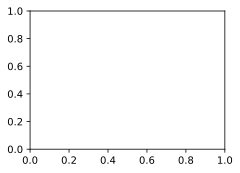

In [40]:
log = open('printlog', 'w')
lr, num_epochs= 0.1, 100
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

device = torch.device('cuda:0')
print('training on', device)
scaler = GradScaler()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.CrossEntropyLoss()
timer, num_batches = Timer(), len(train_iter)

best_acc = 0.85
for epoch in range(num_epochs):
   
    # 训练损失之和，训练准确率之和，样本数
    metric = Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
        timer.start()
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        # 混合精度
        with autocast():
            y_hat = net(X)
            l = loss(y_hat, y)
        scaler.scale(l).backward()
        scaler.step(optimizer)
        scaler.update()
        
        with torch.no_grad():
            metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
        timer.stop()
        train_l = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches,
                         (train_l, train_acc, None))
    scheduler.step()    
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'resnet18.params')
        torch.save(best_acc, 'best_acc')
        print('better test_acc', file=log, flush=True)
    print(f'train loss: {train_l}, train acc: {train_acc}, test acc: {test_acc}', file=log, flush=True)
    animator.add(epoch + 1, (None, None, test_acc))
print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
      f'test acc {test_acc:.3f}')
print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
      f'on {str(device)}')
print(f' total time {timer.sum()}')